In [1]:
"""
Pseudo-tetris

The vertical chamber starts off empty, and is 7 columns wide.

Rocks drop down the chamber, 1 rock at a time.

The rocks spawn in this pattern sequentially (A "#" indicates a rock, and "." indicates an empty space):
---
1. A dash:
..####.

2. A plus:
...#...
..###..
...#...

3. A backwards 'L':
....#..
....#..
..###..

4. A pipe:
..#....
..#....
..#....
..#....

5. A box:
..##...
..##...
---

Rock movement follows these rules:
Before a rock starts falling, 3 empty rows are created above the highest rock / floor.
The rock pattern is added above the empty rows.
A rock can only fall 1 row at a time, and can only move left or right 1 column at a time.
A rock "collides" if its "#" would overlap with another #, the floor, or the wall when attempting to move.
A rock moving left or right does not move sideways if it would collide.
A rock falling down does not fall if it would collide, and instead stops falling.
A rock that stops falling is considered "stopped" and can no longer move.
A new rock starts falling when the previous rock is stopped.
"""

"""
Input is a string of '<' and '>' characters, representing the left and right.
At each step, the current rock falls one row, and the input pushes the falling rock to the left or right.
If the rock cannot fall one row because of another rock or the floor, it stops.
If the rock cannot move left or right because of the wall or another rock, it ignores the input.
When the rock stops, the next rock starts falling.
"""

"""
The rocks are falling in a vertical chamber that is 7 columns wide.
The first rock starts falling 3 rows above the floor, and 2 columns from the left wall.
All subsequent rocks start falling 3 row above the highest stopped rock, and 2 columns from the left wall.
"""

"""
To visualize the current game state, use the following base as the chamber, and extend up as needed:
|.......|
|.......|
|.......|
+-------+
Where - and | are the floor and walls, and . is an empty space.
When rocks are stopped, they are represented by #.
When rocks are falling, they are represented by @.
"""

"""
For the example input: >>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>

The first rock begins falling:
|..@@@@.|
|.......|
|.......|
|.......|
+-------+

Jet of gas pushes rock right:
|...@@@@|
|.......|
|.......|
|.......|
+-------+

Rock falls 1 unit:
|...@@@@|
|.......|
|.......|
+-------+

Jet of gas pushes rock right, but nothing happens:
|...@@@@|
|.......|
|.......|
+-------+

Rock falls 1 unit:
|...@@@@|
|.......|
+-------+

Jet of gas pushes rock right, but nothing happens:
|...@@@@|
|.......|
+-------+

Rock falls 1 unit:
|...@@@@|
+-------+

Jet of gas pushes rock left:
|..@@@@.|
+-------+

Rock falls 1 unit, causing it to come to rest:
|..####.|
+-------+

A new rock begins falling:
|...@...|
|..@@@..|
|...@...|
|.......|
|.......|
|.......|
|..####.|
+-------+
"""

import sys
import gmpy2
from aenum import Enum
import logging

In [2]:
# Globals and helper functions

num_columns = 7

# bit wise representation of a chamber row num_columns wide with walls on each side - 100000001
ROW = 0b1 << num_columns + 1 | 0b1
row_width = ROW.bit_length()

def chunkstring(string, length):
    return (string[0+i:length+i] for i in range(0, len(string), length))

def rows_count(bitwise, row_width = row_width):
    return -(bitwise.bit_length() // -row_width)

def render(bitwise, row_width = row_width):
    output_rows = rows_count(bitwise, row_width)
    chamber_str = format(bitwise, '0' + str(output_rows * row_width) + 'b')
    return chunkstring(chamber_str, row_width)

# somewhat surprisingly, this scales extraordinarily well compared to << and | operators
def block_of_rows(row_count):
    row_str = bin(ROW)[2:]
    return int('0b' + row_str * row_count, 2)

def cstr(chamber, joiner = "\n", affix='-' * row_width):
    if affix != "": affix = "\n" + affix
    return joiner.join(list(render(chamber)))+affix
    
def cprt(chamber):
    for row in render(chamber): print(row)
    print('-'*row_width, end="\n\n")
    

In [3]:
# Shapes

# bit wise representation of a "dash" rock, padded for walls on each side with 2 spaces from the left wall
# Shape:
# ####
DASH = 0b000111100

# bit wise representation of a "plus" rock, padded for ROW with 2 spaces from the left wall
# Shape:
# .#.
# ###
# .#.
PLUS = 0b000010000000111000000010000

# bit wise representation of a "backwards L" rock, padded for ROW with 2 spaces from the left wall
# Shape:
# ..#
# ..#
# ###
BACKWARDS_L = 0b000001000000001000000111000

# bit wise representation of a "pipe" rock, padded for ROW with 2 spaces from the left wall
# Shape:
# #
# #
# #
# #
PIPE = 0b000100000000100000000100000000100000

# bit wise representation of a "box" rock, padded for ROW with 2 spaces from the left wall
# Shape:
# ##
# ##
BOX = 0b000110000000110000

ShapeDict = {
    'DASH': DASH,
    'PLUS': PLUS,
    'BACKWARDS_L': BACKWARDS_L,
    'PIPE': PIPE,
    'BOX': BOX
}

In [4]:
# Shape rendering tests

# render ROW in to its binary representation
# Expected output:
# ---
# TEST ROW:
# 100000001
print("TEST ROW:", end = "")
assert "\n".join(render(ROW)) == "100000001"
print("PASSED")
# for row in render(ROW): print(row)
# print()

# render DASH in to its binary representation
# Expected output:
# ---
# TEST DASH:
# 000111100
print("TEST DASH:", end = "")
assert "\n".join(render(DASH)) == "000111100"
print("PASSED")
# for row in render(DASH): print(row)
# print()

# render PLUS in to its binary representation
# Expected output:
# ---
# TEST PLUS:
# 000010000
# 000111000
# 000010000
print("TEST PLUS:", end = "")
assert "\n".join(render(PLUS)) == "000010000\n000111000\n000010000"
print("PASSED")
# for row in render(PLUS): print(row)
# print()

# render BACKWARDS_L in to its binary representation
# Expected output:
# ---
# TEST BACKWARDS_L:
# 000001000
# 000001000
# 000111000
print("TEST BACKWARDS_L:", end = "")
assert "\n".join(render(BACKWARDS_L)) == "000001000\n000001000\n000111000"
print("PASSED")
# for row in render(BACKWARDS_L): print(row)
# print()

# render PIPE in to its binary representation
# Expected output:
# ---
# TEST PIPE:
# 000100000
# 000100000
# 000100000
# 000100000
print("TEST PIPE:", end = "")
assert "\n".join(render(PIPE)) == "000100000\n000100000\n000100000\n000100000"
print("PASSED")
# for row in render(PIPE): print(row)
# print()

# render BOX in to its binary representation
# Expected output:
# ---
# TEST BOX:
# 000110000
# 000110000
print("TEST BOX:", end = "")
assert "\n".join(render(BOX)) == "000110000\n000110000"
print("PASSED")
# for row in render(BOX): print(row)
# print()

# render a dash inside of a ROW
# Expected output:
# ---
# TEST DASH IN ROW:
# 100111101
print("TEST DASH IN ROW:", end = "")
assert "\n".join(render(ROW | DASH)) == "100111101"
print("PASSED")
# for row in render(ROW | DASH): print(row)
# print()

# render 3 rows of ROWs
# Expected output:
# ---
# TEST 3 ROWS:
# 100000001
# 100000001
# 100000001
print("TEST 3 ROWS:", end = "")
assert "\n".join(render(block_of_rows(3))) == "100000001\n100000001\n100000001"
print("PASSED")
# for row in render(block_of_rows(3)): print(row)
# print()

# render a dash inside of 3 rows of ROWs
# Expected output:
# ---
# TEST DASH IN 3 ROWS:
# 100000001
# 100111101
# 100000001
print("TEST DASH IN 3 ROWS:", end = "")
assert "\n".join(render(block_of_rows(3) | DASH << row_width)) == "100000001\n100111101\n100000001"
print("PASSED")
# for row in render(block_of_rows(3) | DASH << row_width): print(row)
# print()


TEST ROW:PASSED
TEST DASH:PASSED
TEST PLUS:PASSED
TEST BACKWARDS_L:PASSED
TEST PIPE:PASSED
TEST BOX:PASSED
TEST DASH IN ROW:PASSED
TEST 3 ROWS:PASSED
TEST DASH IN 3 ROWS:PASSED


In [5]:
# Shape in to rows tests

# render a box at the top of 3 rows of ROWs
# Expected output:
# ---
# TEST BOX IN 3 ROWS:
# 100110001
# 100110001
# 100000001
print("TEST BOX IN 3 ROWS:", end = "")
# for row in render(block_of_rows(3) | BOX << row_width): print(row)
assert "\n".join(render(block_of_rows(3) | BOX << row_width)) == "100110001\n100110001\n100000001"
print("PASSED")

# Render a dash inside of 3 rows of ROWs and shift right 1 position
# Input: 3 rows of ROWs with a dash on the 2nd row
# Operation: Shift right 1 position
# Expected output:
# ---
# TEST DASH IN 3 ROWS SHIFTED RIGHT:
# 100000001
# 100011111
# 100000001
print("TEST DASH IN 3 ROWS SHIFTED RIGHT:", end = "")
test = block_of_rows(3) | DASH << row_width >> 1
# print() or cprt(test)
assert cstr(test, affix="") == "100000001\n100011111\n100000001"
print("PASSED")

# Render a backwards L inside of 3 rows of ROWs and shift left 1 position
# Input: 3 rows of ROWs with a backwards L on the 2nd row
# Operation: Shift left 1 position
# Expected output:
# ---
# TEST BACKWARDS_L IN 3 ROWS SHIFTED LEFT:
# 100010001
# 100010001
# 101110001
print("TEST BACKWARDS_L IN 3 ROWS SHIFTED LEFT:", end = "")
test = block_of_rows(3) | BACKWARDS_L << 1
# print() or cprt(test)
assert cstr(test, affix="") == "100010001\n100010001\n101110001"
print("PASSED")



TEST BOX IN 3 ROWS:PASSED
TEST DASH IN 3 ROWS SHIFTED RIGHT:PASSED
TEST BACKWARDS_L IN 3 ROWS SHIFTED LEFT:PASSED


In [577]:


import datetime
import time


class Direction(Enum):
    LEFT = '<'
    RIGHT = '>'
    UP = '^'
    DOWN = 'v'

    def longdesc(self):
        if self == Direction.LEFT:
            return "left"
        elif self == Direction.RIGHT:
            return "right"
        elif self == Direction.UP:
            return "up"
        elif self == Direction.DOWN:
            return "down"

class BlockSpawner:
    def __init__(self, spawn_sequence):
        self.spawn_sequence = spawn_sequence
        self.spawn_index = 0
        self.spawn_cycle_count = 0
        self.last_block = 0

    def next_block(self):
        block = self.spawn_sequence[self.spawn_index]
        self.spawn_index += 1
        if self.spawn_index >= len(self.spawn_sequence):
            self.spawn_index = 0
            self.spawn_cycle_count += 1
        self.last_block = block
        return block

class ChamberState:
    def __init__(self, chamber = 0, stopped_blocks = 0, current_block = 0, block_spawner = None):
        self.chamber = chamber
        self.stopped_blocks = stopped_blocks
        self.current_block = current_block
        self.block_spawner = block_spawner
        self.blocks_dropped = 0
        
        self._stopped_rows = 0
        self._forgotten_rows = 0
        
        if block_spawner is None:
            block_spawner = BlockSpawner([DASH, PLUS, BACKWARDS_L, PIPE, BOX])

        self.block_spawner = block_spawner

    def next_block(self):
        self.current_block = self.block_spawner.next_block()
        return self.current_block

    def __str__(self):
        return "ChamberState(chamber = {}, stopped_blocks = {}, current_block = {}, blocks_dropped = {})".format(self.chamber, self.stopped_blocks, self.current_block, self.blocks_dropped)

    def __repr__(self):
        return self.__str__()

    def render(self):
        return cstr(self.chamber | self.stopped_blocks | self.current_block)

    def block_height(self):
        return self._stopped_rows + self._forgotten_rows

    def spawn_rock(self, block_type = 0):
        if self.current_block != 0:
            return self
        
        # logging.info("A new rock begins falling:")
        if block_type == 0:
            current_block = self.next_block()
        else:
            current_block = block_type

        # keep our chamber short by removing rows from the bottom of stopped blocks, past the height of the shortest column
        blocked_str = format(self.stopped_blocks, '0' + str(self._stopped_rows * row_width) + 'b')
        last_1 = max([blocked_str[x::9].find('1') for x in range(1,8)]) + 1
        if last_1 > 0:
            short_blocks = int(blocked_str[0:last_1 * 9], 2)
            short_rows = rows_count(short_blocks)
            rows_removed = self._stopped_rows - short_rows
            # logging.debug("removing {} rows from the bottom of the stopped blocks, was length {} and now is {}".format(rows_removed, self._stopped_rows, short_rows))
            self._forgotten_rows += rows_removed
            self.stopped_blocks = short_blocks
            self._stopped_rows = short_rows
            # logging.debug("self._forgotten_rows is now {}, block rows are {}".format(self._forgotten_rows, self._stopped_rows))

        spawn_height = (self._stopped_rows + 3) + rows_count(self.current_block)
        self.current_block <<= row_width * (spawn_height - rows_count(self.current_block))
        
        # we *could* do a comparison here, but its not as fast as just blindly rebuilding an appropriately sized chamber
        self.chamber = block_of_rows(spawn_height)
        # to_grow = spawn_height - rows_count(self.chamber)
        # if to_grow > 0:
        #     addl_rows = block_of_rows(to_grow)
        #     self.chamber |= addl_rows << row_width * (rows_count(self.chamber))

        # logging.info(self.render())
        return self

    def _move_block(self, direction: Direction, current_block):
        if direction == Direction.LEFT:
            return current_block << 1
        elif direction == Direction.RIGHT:
            return current_block >> 1
        elif direction == Direction.UP:
            return current_block << row_width
        elif direction == Direction.DOWN:
            return current_block >> row_width
        else:
            return current_block

    def advance(self, direction: Direction):
        self.spawn_rock()
        current_count = gmpy2.mpz(self.chamber | self.stopped_blocks | self.current_block).bit_count()
        shifted_block = self._move_block(direction, self.current_block)
        collision_check_count = gmpy2.mpz(self.chamber | self.stopped_blocks | shifted_block).bit_count()
        if current_count == collision_check_count:
            self.current_block = shifted_block
            # if direction == Direction.DOWN:
            #     logging.info("Rock falls 1 unit")
            # else:
            #     logging.info("Jet of gas pushes rock " + direction.longdesc())
        else:
            if direction == Direction.DOWN:
                self.stopped_blocks = self.stopped_blocks | self.current_block
                self._stopped_rows = rows_count(self.stopped_blocks)
                self.current_block = 0
                self.blocks_dropped += 1
            #     logging.info("Rock falls 1 unit, causing it to come to rest")
            # else:
            #     logging.info("Jet of gas pushes rock " + direction.longdesc() + ", but nothing happens")
        # logging.info(self.render())
        
        return self


# read input file for jet of gas commands, e.g., <<<>>><>>>>
commands = ""
with open("day17-input.txt", "r") as f:
    commands = f.read().strip()

current_chamber = ChamberState()
steps_taken = 0
drop_target = 500000

logs = []
# print ("Steps Taken","Rows Of Blocks","Blocks Dropped","Time (s)","Log Type", sep = "\t")
logs.append(["Steps Taken","Rows Of Blocks","Blocks Dropped","Block Type", "Time (s)","Log Type"])

start_time = time.time()
# infinitely loop over commands while dropping blocks, until 2022 blocks have dropped
while current_chamber.blocks_dropped < drop_target:
    # print(steps_taken, current_chamber.block_height(), current_chamber.blocks_dropped, time.time() - start_time, "COMMAND", sep = "\t")
    # logs.append([steps_taken, current_chamber.block_height(), current_chamber.blocks_dropped, time.time() - start_time, "COMMAND"])

    for command in commands:
        # if steps_taken > 10:
        if current_chamber.blocks_dropped >= drop_target:
            break
        current_chamber.advance(Direction(command))        
        steps_taken += 1
        # if steps_taken % 100 == 0:
            # logs.append([steps_taken, current_chamber.block_height(), current_chamber.blocks_dropped, time.time() - start_time, "STEP"])
        # get block name from ShapeDict key for value current_chamber.block_spawner.last_block
        dropping_block = [k for k, v in ShapeDict.items() if v == current_chamber.block_spawner.last_block][0]
        current_chamber.advance(Direction.DOWN)
        if current_chamber.current_block == 0: # and current_chamber.blocks_dropped % 50 == 0:
            logs.append([steps_taken, current_chamber.block_height(), current_chamber.blocks_dropped, dropping_block, time.time() - start_time, "DROP"])
        if (current_chamber.blocks_dropped >= drop_target):
            break

# for log in logs:
#     print(*log, sep = "\t")

In [578]:
# print the first 2 and last 2 lines of the log
print(*logs[0:3], sep = "\n")
print("...")
print(*logs[-2:], sep = "\n")

# total height
print("Total height of the fallen blocks is {} rows after {} blocks dropped and {} steps taken".format(current_chamber.block_height(), current_chamber.blocks_dropped, steps_taken))
# print("Total height of the fallen blocks is {} rows after {} blocks dropped".format(current_chamber.block_height(), current_chamber.blocks_dropped))

['Steps Taken', 'Rows Of Blocks', 'Blocks Dropped', 'Block Type', 'Time (s)', 'Log Type']
[4, 1, 1, 'DASH', 0.0003540515899658203, 'DROP']
[8, 4, 2, 'PLUS', 0.0004940032958984375, 'DROP']
...
[2883037, 794618, 499999, 'PIPE', 75.64515995979309, 'DROP']
[2883041, 794620, 500000, 'BOX', 75.64526510238647, 'DROP']
Total height of the fallen blocks is 794620 rows after 500000 blocks dropped and 2883041 steps taken


In [79]:
import pyperclip
# copy the log to the clipboard
pyperclip.copy("\n".join([str(x) for x in logs]))

# ((1000000000000 / 1000000) * 43.4) / 60 / 60

In [579]:
import stumpy
import pandas as pd
import matplotlib.pyplot as plt

# turn on interactive plots
plt.ion()

df = pd.DataFrame(logs[1:], columns = logs[0])


Steps Taken              4
Rows Of Blocks           1
Blocks Dropped           1
Block Type            DASH
Time (s)          0.000542
Log Type              DROP
Name: 0, dtype: object

In [580]:
rows_delta = df['Rows Of Blocks'] - df['Rows Of Blocks'].shift(1)
rows_delta[0] = 1
df['Rows-D'] = rows_delta
df.loc[0]

Steps Taken              4
Rows Of Blocks           1
Blocks Dropped           1
Block Type            DASH
Time (s)          0.000354
Log Type              DROP
Rows-D                 1.0
Name: 0, dtype: object

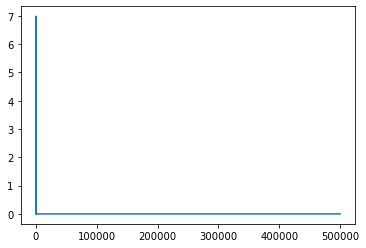

In [581]:
# find the repeating window of df['Rows-D']
m = 50
profile = stumpy.stump(df['Rows-D'], m)
fig, ax = plt.subplots()
ax.plot(profile[:, 0])



1000

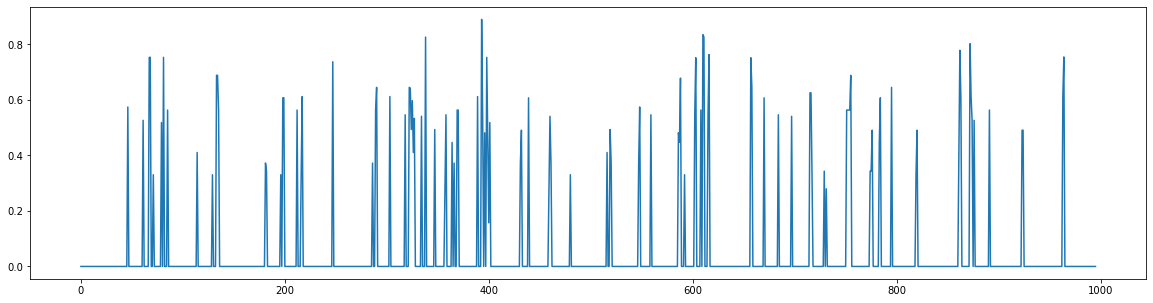

In [576]:
import numpy as np
# plot Rows/Drops
plt.figure(figsize = (20, 5))
m = 5
profile = stumpy.stump(df['Rows-D'], m)
plt.plot(profile[:, 0])

len(df)

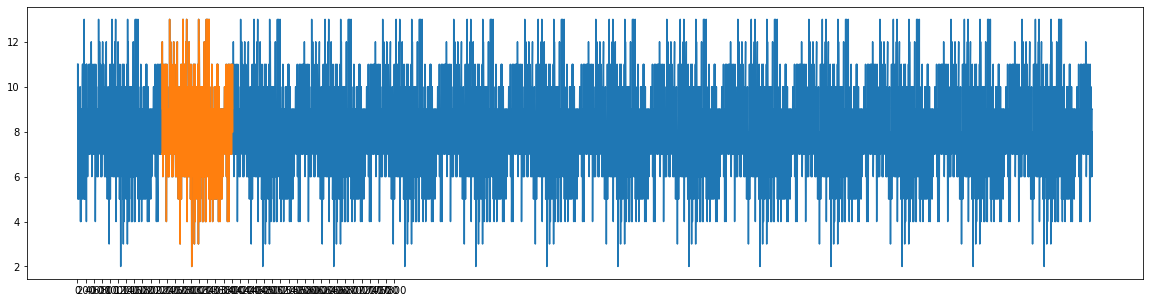

In [777]:
# chunk df in to 5s

sets_df = df.groupby('Chunk').agg({'Rows-D': 'sum', 'Blocks Dropped': 'max', 'Rows Of Blocks': 'max'}).copy()

plt.figure(figsize = (20, 5))

# sets_df[0:1000]

# sets_df['Rows-D']
plt.xticks(np.arange(0, 8000, 200))
plt.title(None)
plt.plot(sets_df['Blocks Dropped'][0:5000], sets_df['Rows-D'][0:5000])
plt.plot(sets_df['Blocks Dropped'][415:765], sets_df['Rows-D'][415:765])


In [774]:
base = 415
m = 765 - base
print("base = {}, m = {}".format(base, m))

for i in range(1, 5):
    print(base + (i * m), base + (i * m) + m, sets_df['Rows-D'][base + (i * m):base + (i * m) + m].sum())

display(sets_df.loc[base])
display(sets_df.loc[base + m])

3830 - 2080

base = 415, m = 350
765 1115 2781.0
1115 1465 2781.0
1465 1815 2781.0
1815 2165 2781.0


Rows-D               7.0
Blocks Dropped    2080.0
Rows Of Blocks    3317.0
Name: 415, dtype: float64

Rows-D               7.0
Blocks Dropped    3830.0
Rows Of Blocks    6098.0
Name: 765, dtype: float64

1750

In [775]:
target = 1000000000000

# the magic numbers we found by looking at the plot really hard
base = 2080
m = 1750

print()
print("target", target, "base", base, "m", m)
windows = (target - base) // m
range_size = windows * m
print("windows {} * {} = {} range size".format(windows, m, range_size))
end_stop_size = target - range_size - base
print("end stop size", end_stop_size)
end_stop_rows = int(df['Rows-D'][base:base+end_stop_size].sum())
base_rows = int(df['Rows-D'][0:base].sum())
print("base rows (0:{})={}".format(base, base_rows))
range_rows = int(df['Rows-D'][base:base+m].sum() * windows)
print("range rows ({}:{}+{})={} * {} = {}".format(base, base, m, df['Rows-D'][base:base+m].sum(), windows, range_rows))
print("end stop rows", end_stop_rows, " calc from ({}:{}+{})={}".format(base, base, end_stop_size, df['Rows-D'][base:base+end_stop_size].sum()))
print("total rows", base_rows + range_rows + end_stop_rows)

# 1589142857183

# Finally!


target 1000000000000 base 2080 m 1750
windows 571428570 * 1750 = 999999997500 range size
end stop size 420
base rows (0:2080)=3317
range rows (2080:2080+1750)=2781.0 * 571428570 = 1589142853170
end stop rows 696  calc from (2080:2080+420)=696.0
total rows 1589142857183
